# Cell cycle model 

## Build the model by importing parameters, reactions and rate laws, and define functions that enable simulation of the cell cycle 

### hit shift+Enter to run the code below

In [12]:
using DifferentialEquations, DataFrames, Plots, CSV, Sundials, JLD2, OrdinaryDiffEq, DelimitedFiles

In [13]:
function condition(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      #numberator: Rb + E2F:Rb +  pE2F:Rb
      #denominator: Rb + E2F:Rb +  pE2F:Rb + hypophosphorylated Rb
      include(locationOfVariableNames)
      indexOfRb=findfirst(x->"Rb"==x,syms)
      indexOfE2FRb=findfirst(x->"E2F_Rb"==x,syms)
      indexOfpE2FRb=findfirst(x->"pE2F_Rb"==x,syms)
      indexOfHypoPRb=findfirst(x->"HypoP_Rb"==x,syms)
      #numberator: Rb + E2F:Rb +  pE2F:Rb
      #denominator: Rb + E2F:Rb +  pE2F:Rb + hypophosphorylated Rb
      numerator= cellcycle[indexOfRb]+cellcycle[indexOfE2FRb]+cellcycle[indexOfpE2FRb];  #ACTIVE RB
      denominator = numerator+cellcycle[indexOfHypoPRb]; #TOTAL RB

      #GM growth (biosynthesis of ribosomes and all necessary machinery)
      #previous iterations had numerator/denominator<0.8
      #diffEq.jl requires a function that hits 0
      (numerator/denominator)-0.8
end

function affect!(integrator)
  print("r31 event to 0\n")
  #update r31Switch to 0
  include(locationOfVariableNames)
  indexOfSwitch=findfirst(x->"r31switch"==x,syms)
  integrator.u[indexOfSwitch] = 0
end

function affectNeg!(integrator)
  print("r31 event to 1\n")
  include(locationOfVariableNames)
  indexOfSwitch=findfirst(x->"r31switch"==x,syms)
  #update r31Switch to 1
  integrator.u[indexOfSwitch] = 1
end

function conditionCdh(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      include(locationOfVariableNames)
      indexOfCdh1=findfirst(x->"Cdh1"==x,syms)
      #triggers when Cdh1 crosses 0.2 in the positive direction
      cellcycle[indexOfCdh1]-0.2
end

## all equal function
function allequal(obj)
    local x
    isfirst = true
    for i in obj
        if isfirst
            x = i
            isfirst = false
        else
            isequal(x, i) || return false
        end
    end
    return true
end

function affectCdh!(integrator)
  include(locationOfVariableNames)
  indexOfMass=findfirst(x->"Mass"==x,syms)
  indexOfGM=findfirst(x->"GM"==x,syms)
  indexNewSwitch=findfirst(x->"newSwitch"==x,syms)

  #triggers when Cdh1 crosses 0.2 in the positive direction
  #update Mass to 0.5* mass

  # get mass value just before divide
  mass_cyc = integrator.u[indexOfMass]
  time = integrator.t
  # push mass value to array
  push!(mass_array, mass_cyc)
  # push mass peak time to array
  push!(mass_peak_time, time)
  # if mass_array > 5, round mass values, and compare last 5
  n=size(mass_array,1)
  if n>6
    mass_array_last = last(mass_array, 6)
    mass_array_rnd = round.(mass_array_last, digits = 3)
    if allequal(mass_array_rnd) == true
      terminate!(integrator)
      return(mass_array, mass_peak_time)
    else
  integrator.u[indexOfMass] = 0.5*integrator.u[indexOfMass]
  #Gm to 0.5 * Gm
  integrator.u[indexOfGM]=0.5*integrator.u[indexOfGM]
end
end
  if integrator.u[indexOfMass]<0.5
    print("new switch 0 during division\n")
    integrator.u[indexNewSwitch]=0
  else
    print("new switch 1 during division\n")
    integrator.u[indexNewSwitch]=1
  end
  print("division event\n")
end

## extra functions to stop the cell cycling when mass drops below 0.5

function conditionMass(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      include(locationOfVariableNames)
      indexMass=findfirst(x->"Mass"==x,syms)
      #triggers when mass crosses 0.5
      cellcycle[indexMass]-0.5
end

function affectMass!(integrator)
    include(locationOfVariableNames)
    indexNewSwitch=findfirst(x->"newSwitch"==x,syms)
    integrator.u[indexNewSwitch] = 1
    print("new switch 1\n")
end

function affectMassNeg!(integrator)
    include(locationOfVariableNames)
    indexNewSwitch=findfirst(x->"newSwitch"==x,syms)
    integrator.u[indexNewSwitch] = 0
    print("new switch 0\n")
end

condition (generic function with 1 method)

In [22]:
#use the callbacks described above to trigger events
cb = ContinuousCallback(condition,affect!,affectNeg!)
cb2 = ContinuousCallback(conditionCdh,affectCdh!,nothing)
cb3 = ContinuousCallback(conditionMass,affectMass!,affectMassNeg!)
cbs=CallbackSet(cb,cb2,cb3)

ContinuousCallback{typeof(condition), typeof(affect!), typeof(affectNeg!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affectNeg!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, nothing, DiffEqBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1//100)

### This function calculates the time point in the solution of the model at which transitions between different
### stages of the cell cycle occur.

In [26]:
function Get_CC_transitions(sol_df)
  Cdh1_col = columnindex(sol_df, :Cdh1)
  cycA_col = columnindex(sol_df, :cycA)
  cycB_col = columnindex(sol_df, :cycB)
  cycE_col = columnindex(sol_df, :cycE)
  Mass_col = columnindex(sol_df, :Mass)

  sol_SS_cc = sol_SS[:, [Cdh1_col,cycA_col,cycB_col,cycE_col,Mass_col]]

  # G1 -> S boundary when cycB is > 0 (or close to 0)cycB_peak_df = convert_colname(max_cycB[2])
  # S to G2 when CycE is gone but before peak in CycA
  # G2 to M at peak of CycB before rapid decrease in CycB, CycA should already be decreasing and about half way gone.

  SS_zero = convert(Int64, round(time_stamp_SS[1], digits=0))

  ##G1/S
  max_Cdh1 = findmax(sol_SS_cc[:,1])
  submax_Cdh1 = (max_Cdh1[1]/100)*95
  submax_Cdh1 = findfirst(x->x>submax_Cdh1, sol_SS_cc[:,1])
  G1S_df = sol_SS_cc[submax_Cdh1:nrow(sol_SS_cc),:]
  col_Cdh1 = G1S_df[:,1]  
  half_max_Cdh1 = max_Cdh1[1]*0.5
  G1S=findfirst(x->x<half_max_Cdh1,col_Cdh1)
  G1S_t = convert(Int64, round(time_stamp_SS[G1S+submax_Cdh1],digits=0))
  G1S_t = G1S_t - SS_zero
    
  ## S/G2
  G1St = SS_zero+G1S_t
  G1St_TS = findfirst(x->x>G1St, time_stamp_SS)
  # get max value of cycA
  colcycA = sol_SS_cc[:,2]
  max_cycA = findmax(colcycA[G1St_TS:end])
  # get time when cycA is max - 2.5%
  submaxA = (max_cycA[1]/100)*97.5
  submaxA = findfirst(x->x>submaxA,colcycA)
  SG2_t = convert(Int64, round(time_stamp_SS[submaxA],digits=0))
  SG2_t = SG2_t - SS_zero

  ## G2/M
  SG2t = SS_zero+SG2_t
  SG2t_TS = findfirst(x->x>SG2t, time_stamp_SS)
  col_cycB = sol_SS_cc[:,3]
  max_cycB = findmax(col_cycB[SG2t_TS:end])
  #submaxB = (max_cycB[1]/100)*97.5
  max_cycB = findfirst(x->x==max_cycB[1],col_cycB)
  G2M_time = convert(Int64, round(time_stamp_SS[max_cycB],digits=0))
  G2M_t = G2M_time - SS_zero

  ## M
  M_t = convert(Int64, round(time_stamp[SS_end],digits=0)) - SS_zero

  return(G1S_t,SG2_t,G2M_t,M_t)

end

Get_CC_transitions (generic function with 1 method)

### Here we import csv files containing all the information required to build a model file of 
### ordinary differential equations

In [27]:
### Files
reactionsFile="moduleDefinitionFiles/cellCycle/reactions_plus_myc2.csv"
parametersFile="moduleDefinitionFiles/cellCycle/parameters_plus_myc.csv"
rateLawsFile="moduleDefinitionFiles/cellCycle/rateLaws_plus_myc2.csv"
arguments=[reactionsFile, parametersFile, rateLawsFile, "odeCellCycle.jl", "scan"]
locationOfCSV2Julia="CSV2JuliaDiffEq/csv2model.py"
cmd=`python3 $locationOfCSV2Julia $arguments`
run(cmd)

"moduleDefinitionFiles/cellCycle/rateLaws_plus_myc2.csv"

In [31]:
mkpath("modelFiles/cellCycle/")
mv("odeCellCycle.jl","modelFiles/cellCycle/odeCellCycle.jl", force=true)
mv("variableNames.jl","modelFiles/cellCycle/variableNamesCellCycle.jl", force=true)
include("modelFiles/cellCycle/odeCellCycle.jl")
include("modelFiles/cellCycle/variableNamesCellCycle.jl")
include("scanIncludes.jl")
locationOfVariableNames="modelFiles/cellCycle/variableNamesCellCycle.jl"

"modelFiles/cellCycle/variableNamesCellCycle.jl"

## Set initial conditions

In [34]:
#initial conditions:
#"ERG","p27_cycA_Cdk2","p27","Cdc20","p27_cycE_Cdk2","cycE","cycA",
#"cycB","p27_cycD_Cdk2","cycD","Cdh1","DRG","PPX","IEP","Cdc20t","E2F_Rb",
#"E2F","HypoP_Rb","pE2F_Rb","pE2F","GM","r31switch","cMyc","Mass","newSwitch","Rb","cMyct",]
inits=[0.0121809,0.0356927,0.00922806,0.00220177,0.000542587,0.0229112, 1.4094,
      2.72898,0.010976,0.43929,0.000653278,0.900533,1.0,0.154655,2.36733,0.00478911,
      0.989986,9.97574,0.0192822,3.98594,1.35565,1,40,1,1,0,40]

27-element Vector{Float64}:
  0.0121809
  0.0356927
  0.00922806
  0.00220177
  0.000542587
  0.0229112
  1.4094
  2.72898
  0.010976
  0.43929
  0.000653278
  0.900533
  1.0
  ⋮
  0.00478911
  0.989986
  9.97574
  0.0192822
  3.98594
  1.35565
  1.0
 40.0
  1.0
  1.0
  0.0
 40.0

In [35]:
syms=Symbol.(syms)

27-element Vector{Symbol}:
 :ERG
 :p27_cycA_Cdk2
 :p27
 :Cdc20
 :p27_cycE_Cdk2
 :cycE
 :cycA
 :cycB
 :p27_cycD_Cdk2
 :cycD
 :Cdh1
 :DRG
 :PPX
 ⋮
 :E2F_Rb
 :E2F
 :HypoP_Rb
 :pE2F_Rb
 :pE2F
 :GM
 :r31switch
 :cMyc
 :Mass
 :newSwitch
 :Rb
 :cMyct

In [36]:
### Define the problem
p=1
h(p,t)=inits
params=1

f=ODEFunction(odeFile,syms=syms)
prob=ODEProblem(f,inits,(0.0,10000*60))

1

In [38]:
global colnames=["G1S", "SG2", "G2M", "M"]

4-element Vector{String}:
 "G1S"
 "SG2"
 "G2M"
 "M"

In [39]:
using JLD2, FileIO


### here we will solve the model until we find a steady state, at which point we will calculate the timing of transitions between cell cycle checkpoints

In [ ]:
paramNames = Dict("k1_16" => "ERG_deg", "k1_30" => "CycA_deg", "k1_25R" => "p27_cycE_Cdk2_deg", "k2_5" => "p27_exp", "k1_18" => "DRG_deg", "k1_12" => "Cdc20t_deg",
"k1_13" => "Cdc20_exp1", "k2_j13" => "Cdc20_exp2", "k1_14" => "Cdc20_deg1", "k2_j14" => "Cdc20_deg2",
"k1_10" => "p27_cycD_Cdk2_deg", "k2_mu" => "mass_gain", "k2_15" => "ERG_exp2", "k3_j15" => "ERG_exp3", "k2_11a" => "Cdc20t_exp2", "k3_11" => "Cdc20t_exp3", "k2_29" => "cycA_exp",
"k1_3a" => "Cdh1_exp1", "k2_3" => "Cdh1_exp2", "k3_J3" => "Cdh1_exp3", "k2_1a" => "cycB_exp2", "k3_1" => "cycB_exp3", "k4_j1" => "cycB_exp4",
"k1_23a" => "E2F_phos1", "K2_3a" => "E2F_phos2",
"k2_17" => "DRG_exp2", "k3_j17" => "DRG_exp3", "k4_17a" => "DRG_exp4", "k1_j4" => "Cdh1_deg1", "k2_4" => "Cdh1_deg2", "k3_ga" => "Cdh1_deg3", "k4_gb" => "Cdh1_deg4", "k5_ge" => "Cdh1_deg5",
"k2_1a" => "cycB_exp2", "k3_1" => "cycB_exp3", "k4_j1" => "cycB_exp4", "k2_7a" => "cycE_exp2", "k3_7" => "cycE_exp3", "k1_31" => "IEP_exp1", "k2_j31" => "IEP_exp2",
"k1_8a" => "p27.cycE.Cdk2_degp27_1", "k2_8" => "p27.cycE.Cdk2_degp27_2", "k3_yb" => "p27.cycE.Cdk2_degp27_3", "k4_ye" => "p27.cycE.Cdk2_degp27_4", "k5_j8" => "p27.cycE.Cdk2_degp27_5",
"k1_22" => "pE2F_Rb_dephos", "k1_34" => "PPX_deg",
"k1_25" => "cycAp27_bind_Cdk2", "k1_26" => "E2F_bind_Rb", "k2_23" => "E2F_phos2", "k3_2" => "cycB_deg3", "k2_2a" => "cycB_deg2", "k1_J4" => "Cdh1_deg",
"k1_24r" => "p27_cycD_Cdk2_deg",
"k2_9" => "cycD_exp", "k2_19a" => "Rb_phos2", "k4_21" => "Rb_phos4", "k5_fb" => "Rb_phos5", "k6_fe" => "Rb_phos6",
"k1_6a" => "p27.cycE/D/A.Cdk2_deg1", "k2_6" => "p27.cycE/D/A.Cdk2_deg2", "k3_ha" => "p27.cycE/D/A.Cdk2_deg3", "k4_hb" => "p27.cycE/D/A.Cdk2_deg4", "k5_he" => "p27.cycE/D/A.Cdk2_deg5",
"k1_20" => "E2F_Rb_diss1", "k2_la" => "E2F_Rb_diss2", "k3_lb" => "E2F_Rb_diss3", "k4_ld" => "E2F_Rb_diss4", "k5_le" => "E2F_Rb_diss5",
"k1_24" => "p27.cycD_binds_Cdk2", "k1_2aa" => "cycB_exp1b", "k2_j32" => "IEP_deg2", "k1_26r" => "pE2F_Rb_prod",
"k1_28" => "GM_prod", "k1_19" => "Rb_phos1", "k3_pp1t" => "Rb_phos3")

## Now we're going to run the model
### this will take a few minutes

In [33]:
## create empty arrays that we can append to so we can keep track of the value of the mass of the cell
## and the time when it peaks (just before mitosis) 
global mass_array=[]
global mass_peak_time=[]

## select a parameter to modify and a copy number for modification
modify[**insert parameter here***] = *add copy number* 

## solve the model
@timev sol = solve(prob,callback=cbs) 

save("outputFiles/cellCycle/WT/sol_WT.jld2", "solution", sol)
### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
sol_df = DataFrame(sol', syms)
global time_stamp = sol.t
sol_df[!, :time_stamp] = time_stamp
SS = last(mass_peak_time, 3)
SS_start=findfirst(x->x>SS[1],time_stamp)
global SS_end=findfirst(x->x>SS[2],time_stamp)
SS_nrow = nrow(sol_df) - SS_start
global sol_SS = last(sol_df, SS_nrow)

# find mass zero
Mass_col = columnindex(sol_SS, :Mass)
mass_min = findmin(sol_SS[:, Mass_col])

# SS = mass peak 4 to 5
global sol_SS = first(sol_SS, mass_min[2])          

# get time stamp
global time_stamp_SS = sol_SS[:, 28]
writedlm("outputFiles/cellCycle/WT/time_stamp_SS_WT.csv", time_stamp_SS, ',')

### Calculate times for cell cycle transitions
global plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS))'), colnames)
CSV.write("outputFiles/cellCycle/WT/plot_times_WT.csv", plot_times)   

new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
new switch 1 during division
division event
175.584979 seconds (267.63 M allocations: 5.637 GiB, 1.03% gc time)
elapsed time (ns): 175584978817
gc time (ns):      1

"outputFiles/cellCycle/WT/plot_times_WT.csv"

## Plotting

In [34]:
function Plot_CC_PS(mod, key, t, y=5)
    ## load solution
    sol = load("outputFiles/cellCycle/Param_scan/PS_"*date*"/PS"*string(mod)*"/solutions/sol_"*key*".jld2", "solution")
    
    ## load time stamp
    time_stamp = DataFrame(CSV.File("outputFiles/cellCycle/Param_scan/PS_"*date*"/PS"*string(mod)*"/time_stamps/time_stamp_SS_"*key*".csv", header=false)) 
    rename!(time_stamp, :Column1 => :time)
    
    ## transition times
    plot_times = DataFrame(CSV.File("outputFiles/cellCycle/Param_scan/PS_"*date*"/PS"*string(mod)*"/plot_times/plot_times_"*key*".csv", header=true))
    
    G1_S = trunc(Int, (plot_times[1,1]+time_stamp[1,1]))
    S_G2 = trunc(Int, (plot_times[1,2]+time_stamp[1,1]))
    G2_M = trunc(Int, (plot_times[1,3]+time_stamp[1,1]))
    M = trunc(Int, (plot_times[1,4]+time_stamp[1,1]))
    
    G1S = string(plot_times[1,1])
    SG2 = string(plot_times[1,2])
    G2M = string(plot_times[1,3])
    M_ = string(plot_times[1,4])
    
    ## select steady state
    start=findfirst(x->x==time_stamp[1,1], sol.t)
    #println(start)
    finish=findfirst(x->x==time_stamp[nrow(time_stamp),1], sol.t)+10
    #println(finish)
    sol_SS=sol[start:finish]
    
#     if M > 2400 
#         intervals=string.(0:5:40)
#         xhours=300
#     else intervals=string.(0:1:20)
#         xhours=60
#     end
    
    #plot
    plot(sol, vars=[indexCdh1,indexcycE,indexcycA,indexcycB,indexIEP],
          lc=[:green :yellow :purple :red :blue :orange],
          lw=2.5,
          xlabel="time (hours)",
          xlims=(time_stamp[1,1], time_stamp[nrow(time_stamp),1]+10),
          xticks=(sol.t[start]:120:sol.t[finish], string.(0:2:45)),
          legend= :outertopright,
          ylims=(0,y),
          title = paramNames[key]*" "*mod,
          fmt = :png)    
    vline!([G1_S], color=:black, linestyle=:dash, lw=1, label="G1/S "*G1S*" mins")
    vline!([S_G2], color=:black, linestyle=:dash, lw=1.5, label="S/G2 "*SG2*" mins")
    vline!([G2_M], color=:black, linestyle=:dash, lw=2, label="G2/M "*G2M*" mins")
    vline!([M], color=:black, linestyle=:dash, lw=2.5, label="M "*M_*" mins")
    
end

Plot_CC_PS_WT (generic function with 1 method)

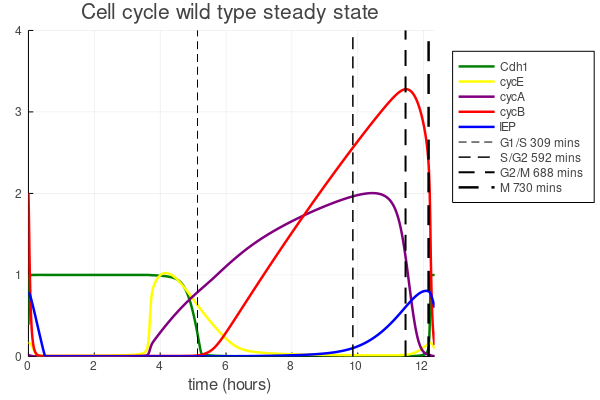

In [47]:
function Plot_CC_PS_WT(sol)
    ## load solution
    sol = load("outputFiles/cellCycle/WT/sol_WT.jld2", "solution")
    
    ## load time stamp
    time_stamp = DataFrame(CSV.File("outputFiles/cellCycle/WT/time_stamp_SS_WT.csv", header=false)) 
    
    rename!(time_stamp, :Column1 => :time)
    
    ## transition times
    plot_times = DataFrame(CSV.File("outputFiles/cellCycle/WT/plot_times_WT.csv", header=true))
    
    G1_S = trunc(Int, (plot_times[1,1]+time_stamp[1,1]))
    S_G2 = trunc(Int, (plot_times[1,2]+time_stamp[1,1]))
    G2_M = trunc(Int, (plot_times[1,3]+time_stamp[1,1]))
    M = trunc(Int, (plot_times[1,4]+time_stamp[1,1]))
    
    G1S = string(plot_times[1,1])
    SG2 = string(plot_times[1,2])
    G2M = string(plot_times[1,3])
    M_ = string(plot_times[1,4])
    
    ## select steady state
    start=findfirst(x->x==time_stamp[1,1], sol.t)
    #println(start)
    finish=findfirst(x->x==time_stamp[nrow(time_stamp),1], sol.t)+10
    #println(finish)
    sol_SS=sol[start:finish]
    
#     if M > 2400 
#         intervals=string.(0:5:40)
#         xhours=300
#     else intervals=string.(0:1:20)
#         xhours=60
#     end
    
    #plot
    plot(sol, vars=[indexCdh1,indexcycE,indexcycA,indexcycB,indexIEP],
          lc=[:green :yellow :purple :red :blue :orange],
          lw=2.5,
          xlabel="time (hours)",
          xlims=(time_stamp[1,1], time_stamp[nrow(time_stamp),1]+10),
          xticks=(sol.t[start]:120:sol.t[finish], string.(0:2:45)),
          legend= :outertopright,
          ylims=(0,4),
          title = "Cell cycle wild type steady state",
          fmt = :png)    
    vline!([G1_S], color=:black, linestyle=:dash, lw=1, label="G1/S "*G1S*" mins")
    vline!([S_G2], color=:black, linestyle=:dash, lw=1.5, label="S/G2 "*SG2*" mins")
    vline!([G2_M], color=:black, linestyle=:dash, lw=2, label="G2/M "*G2M*" mins")
    vline!([M], color=:black, linestyle=:dash, lw=2.5, label="M "*M_*" mins")
    
end

## optional - if you wish to simulate different mutations of the same gene

In [4]:
mut=[1,1.5,2,5]

7-element Vector{Float64}:
   1.0
   1.5
   2.0
   5.0
  10.0
  50.0
 100.0

In [ ]:
#### run my mutation simulation

for (i) in mut
    
    run(cmd)
    
    mkpath("modelFiles/cellCycle/")
    mv("odeCellCycle.jl","modelFiles/cellCycle/odeCellCycle.jl", force=true)
    mv("variableNames.jl","modelFiles/cellCycle/variableNamesCellCycle.jl", force=true)
    
    include("modelFiles/cellCycle/odeCellCycle.jl")
    include("modelFiles/cellCycle/variableNamesCellCycle.jl")
    include("scanIncludes.jl")
    
    println("Solving for " ,i, "...")  
    
    modify["k1_myc"] = i
    
    global mass_array=[]
    global mass_peak_time=[]
            
    ### Solve
    @timev sol = solve(prob,callback=cbs) 
            if length(mass_peak_time) <5
                continue
            else
    save("outputFiles/cellCycle/myc_mut/solutions/sol_"*string(i)*".jld2", "solution", sol)
    ### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
    sol_df = DataFrame(sol', syms)
    global time_stamp = sol.t
    sol_df[!, :time_stamp] = time_stamp
    SS = last(mass_peak_time, 3)
    SS_start=findfirst(x->x>SS[1],time_stamp)
    global SS_end=findfirst(x->x>SS[2],time_stamp)
    SS_nrow = nrow(sol_df) - SS_start
    global sol_SS = last(sol_df, SS_nrow)
            
    # find mass zero
    Mass_col = columnindex(sol_SS, :Mass)
    mass_min = findmin(sol_SS[:, Mass_col])
        
    # SS = mass peak 4 to 5
    global sol_SS = first(sol_SS, mass_min[2])          
      
    # get time stamp
    global time_stamp_SS = sol_SS[:, 28]
    writedlm("outputFiles/cellCycle/myc_mut/time_stamps/time_stamp_SS_"*string(i)*".csv", time_stamp_SS, ',')
        
    ### Calculate times for cell cycle transitions
    global plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS))'), colnames)
    CSV.write("outputFiles/cellCycle/myc_mut/plot_times/plot_times_"*string(i)*".csv", plot_times)    
            end
        
    flush(stdout)
end

In [2]:
## create empty DataFrame for results
plot_times_df_myc = DataFrame(G1S=Int64[], SG2=Int64[], G2M=Int64[], M=Int64[], k1_myc=Float64[])

,G1S,SG2,G2M,M,k1_myc
,Int64,Int64,Int64,Int64,Float64


In [5]:
## find results and add to dataframe

for i in mut
    
plot_times = DataFrame(CSV.File("outputFiles/cellCycle/myc_mut/plot_times/plot_times_"*string(i)*".csv", header=true))
    
plot_times[!, :k1_myc] = [i]
    
append!(plot_times_df_myc, plot_times)
        
end

In [6]:
plot_times_df_myc

,G1S,SG2,G2M,M,k1_myc
,Int64,Int64,Int64,Int64,Float64
1,309,592,688,730,1.0
2,299,585,680,722,1.5
3,297,583,678,719,2.0
4,294,573,672,715,5.0
5,294,573,672,715,10.0
6,295,576,673,715,50.0
7,295,576,673,715,100.0


In [7]:
# get length of each part of the cell cycle from the end times
function res_mod(df)
      for i in 1:nrow(df)
            df[i,4]=df[i,4] - df[i,3]
            df[i,3]=df[i,3] - df[i,2]
            df[i,2]=df[i,2] - df[i,1]
      end
      return(df)
end

res_mod (generic function with 1 method)

In [ ]:
function HistoPlot(plot_times)
    
    CC_res = deepcopy(plot_times[!, 1:4])
    
    CC_res = Matrix(res_mod(CC_res))
    
    G1 = CC_res[:,1]
    S = CC_res[:,2]
    G2 = CC_res[:,3]
    M = CC_res[:,4]
    
    plot_names = plot_times[!, :param]
    
    StatsPlots.groupedbar(plot_names, [M G2 S G1],
            bar_position = :stack,
            bar_width=0.8,
            label=["M" "G2" "S" "G1"],
            #xlims=(0,2e3),
            ytickfont=font(10),
            orientation = :horizontal,
            yticks=:all,
            legend=:outertopright,
            size=(1000,1200))
    s=string.(collect(0:1:15))
    plot!(xticks = (0:(60*1):(60*15),s),xlabel="time (hours)",fmt = :png)
    vline!([309], color=:black, linestyle=:dash, lw=2, label="G1/S WT 309 mins")
    vline!([592], color=:black, linestyle=:dash, lw=2, label="S/G2 WT 592 mins")
    vline!([668], color=:black, linestyle=:dash, lw=2, label="G2/M WT 668 mins")
    vline!([730], color=:black, linestyle=:dash, lw=2, label="M WT 730 mins")
    
end

In [8]:
using StatsPlots

In [31]:
function HistoPlotMyc(plot_times)
    
    CC_res = deepcopy(plot_times[!, 1:4])
    
    CC_res = Matrix(res_mod(CC_res))
    
    G1 = CC_res[:,1]
    S = CC_res[:,2]
    G2 = CC_res[:,3]
    M = CC_res[:,4]
    
    plot_names = ["WT", "x1.5", "x2", "x5", "x10", "x50", "x100"]
    
    StatsPlots.groupedbar(plot_names, [M G2 S G1],
            bar_position = :stack,
            bar_width=0.8,
            #bar_spacing=0.5,
            label=["M" "G2" "S" "G1"],
            xlims=(0,13*60),
            xlabel="Myc copy number",
            ytickfont=font(12),
            xtickfont=font(12),
            xguidefontsize=font(12),
            orientation = :horizontal,
            #yticks=:all,
            legend=:outertopright,
            size=(1200,350)
    )
    s=string.(collect(0:1:13))
    plot!(xticks = (0:(60*1):(60*13),s),xlabel="time (hours)",fmt = :png)
    vline!([309], color=:black, linestyle=:dash, lw=1, label="G1/S WT 309 mins")
    vline!([592], color=:black, linestyle=:dash, lw=2, label="S/G2 WT 592 mins")
    vline!([688], color=:black, linestyle=:dash, lw=3, label="G2/M WT 688 mins")
    vline!([730], color=:black, linestyle=:dash, lw=4, label="M WT 730 mins")
    
end

HistoPlotMyc (generic function with 1 method)

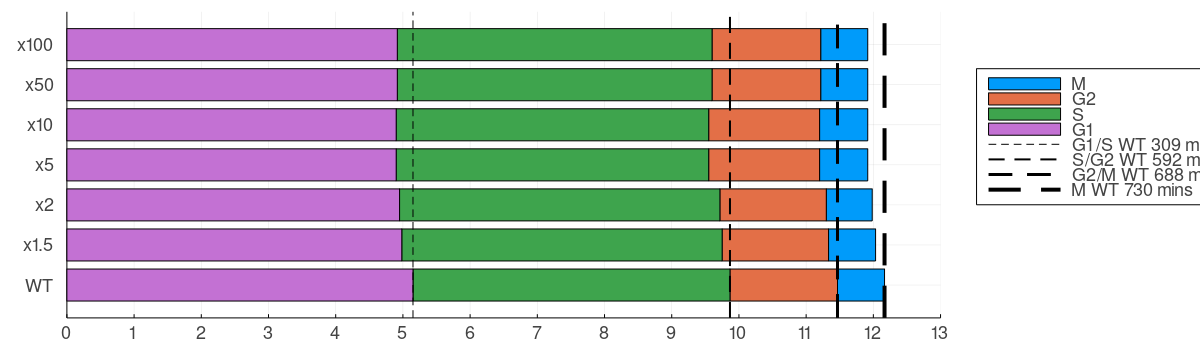

In [32]:
HistoPlotMyc(plot_times_df_myc)

In [44]:
include(locationOfVariableNames)
global indexCdh1=findfirst(x->"Cdh1"==x,syms)
global indexMass=findfirst(x->"Mass"==x,syms)
global indexcycE=findfirst(x->"cycE"==x,syms)
global indexcycA=findfirst(x->"cycA"==x,syms)
global indexcycB=findfirst(x->"cycB"==x,syms)
global indexIEP=findfirst(x->"IEP"==x,syms)
global indexnewSwitch=findfirst(x->"newSwitch"==x,syms)
global indexmyc=findfirst(x->"cMyc"==x,syms)
global indexmyct=findfirst(x->"cMyct"==x,syms)
global indexp27=findfirst(x->"p27_cycE_Cdk2"==x,syms)
global indexcycD=findfirst(x->"cycD"==x,syms)

10

In [ ]:
function Plot_CC_myc(mod, t=0)
    ## load solution
    sol = load("outputFiles/cellCycle/myc_mut/solutions/sol_"*string(mod)*".jld2", "solution")
    
    ## load time stamp
    time_stamp = DataFrame(CSV.File("outputFiles/cellCycle/myc_mut/time_stamps/time_stamp_SS_"*string(mod)*".csv", header=false)) 
    rename!(time_stamp, :Column1 => :time)
    
    ## transition times
    plot_times = DataFrame(CSV.File("outputFiles/cellCycle/myc_mut/plot_times/plot_times_"*string(mod)*".csv", header=true))
    
    G1_S = trunc(Int, (plot_times[1,1]+time_stamp[1,1]))
    S_G2 = trunc(Int, (plot_times[1,2]+time_stamp[1,1]))
    G2_M = trunc(Int, (plot_times[1,3]+time_stamp[1,1]))
    M = trunc(Int, (plot_times[1,4]+time_stamp[1,1]))
    
    G1S = string(plot_times[1,1])
    SG2 = string(plot_times[1,2])
    G2M = string(plot_times[1,3])
    M_ = string(plot_times[1,4])
    
    ## select steady state
    start=findfirst(x->x==time_stamp[1,1], sol.t)
    #println(start)
    finish=findfirst(x->x==time_stamp[nrow(time_stamp),1], sol.t)+10
    #println(finish)
    
    Plots.plot(sol, vars=[indexCdh1,indexMass,indexcycE,indexcycA,indexcycB,indexIEP],
      lc=[:green :yellow :purple :red :blue :orange],
      lw=2.5,
      xlims=(time_stamp[1, :time] + t, time_stamp[nrow(time_stamp), :time] + 10),
      xticks=(sol.t[start]:60:sol.t[finish]+10, string.(0:1:14)),
      xlabel="time (hours)",
      legend= :outertopright,
      ylims=(0,5),
      title = "k1_myc x"*string(mod),
      fmt = :png)
    
#     last_time = trunc(Int, time_stamp[nrow(time_stamp),1]/60)
#     s=string.(collect(0:5:last_time))
#     plot!(xticks = (0:(60*5):(60*last_time),s),xlabel="time (hours)",fmt = :png)
    
    vline!([G1_S], color=:black, linestyle=:dash, lw=1, label="G1/S "*G1S*" mins")
    vline!([S_G2], color=:black, linestyle=:dash, lw=1.5, label="S/G2 "*SG2*" mins")
    vline!([G2_M], color=:black, linestyle=:dash, lw=2, label="G2/M "*G2M*" mins")
    vline!([M], color=:black, linestyle=:dash, lw=2.5, label="M "*M_*" mins")
end

In [ ]:
Plots.plot(sol, vars=[indexCdh1,indexMass,indexcycE,indexcycA,indexcycB,indexIEP],
      lc=[:green :yellow :purple :red :blue :orange],
      lw=2.5,
      xlims=(time_stamp_SS[1], time_stamp_SS[length(time_stamp_SS)] + 10),
      #legend=false,
      legend= :outertopright,
      ylims=(0,5),
      title = "k3_1 x"*string(mod),
      fmt = :png)

In [ ]:
#### run mutation simulation for k2_5 

for (i) in mut
    
    run(cmd)
    
    mkpath("modelFiles/cellCycle/")
    mv("odeCellCycle.jl","modelFiles/cellCycle/odeCellCycle.jl", force=true)
    mv("variableNames.jl","modelFiles/cellCycle/variableNamesCellCycle.jl", force=true)
    
    include("modelFiles/cellCycle/odeCellCycle.jl")
    include("modelFiles/cellCycle/variableNamesCellCycle.jl")
    include("scanIncludes.jl")
    
    println("Solving for " ,i, "...")  
    
    modify["k2_5"] = i
    
    global mass_array=[]
    global mass_peak_time=[]
            
    ### Solve
    @timev sol = solve(prob,callback=cbs) 
            if length(mass_peak_time) <5
                continue
            else
    save("outputFiles/cellCycle/k2_5_mut/solutions/sol_"*string(i)*".jld2", "solution", sol)
    ### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
    sol_df = DataFrame(sol', syms)
    global time_stamp = sol.t
    sol_df[!, :time_stamp] = time_stamp
    SS = last(mass_peak_time, 3)
    SS_start=findfirst(x->x>SS[1],time_stamp)
    global SS_end=findfirst(x->x>SS[2],time_stamp)
    SS_nrow = nrow(sol_df) - SS_start
    global sol_SS = last(sol_df, SS_nrow)
            
    # find mass zero
    Mass_col = columnindex(sol_SS, :Mass)
    mass_min = findmin(sol_SS[:, Mass_col])
        
    # SS = mass peak 4 to 5
    global sol_SS = first(sol_SS, mass_min[2])          
      
    # get time stamp
    global time_stamp_SS = sol_SS[:, 28]
    writedlm("outputFiles/cellCycle/k2_5_mut/time_stamps/time_stamp_SS_"*string(i)*".csv", time_stamp_SS, ',')
        
    ### Calculate times for cell cycle transitions
    global plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS))'), colnames)
    CSV.write("outputFiles/cellCycle/k2_5_mut/plot_times/plot_times_"*string(i)*".csv", plot_times)    
            end
        
    flush(stdout)
end